In [1]:
import numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt

def load_data_flexible(data_path, p_fixed_name='p_proj', p_fixed_value=0.5):
    """
    Load data flexibly - handles individual JSON files, JSON arrays, and JSON Lines format
    """
    json_data = []
    json_files = []
    for root, dirs, files in os.walk(os.path.join(data_path, f'{p_fixed_name}{p_fixed_value}')):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    
    print(f"Found {len(json_files)} JSON files")
    
    for file in json_files:
        with open(file, 'r') as f:
            try:
                # Try to load as regular JSON first (single object or array)
                data = json.load(f)
                if isinstance(data, list):
                    # If it's an array of results, extend the main list
                    json_data.extend(data)
                else:
                    # Single result
                    json_data.append(data)
            except json.JSONDecodeError:
                # If that fails, try JSON Lines format (one JSON object per line)
                f.seek(0)  # Reset file pointer
                line_count = 0
                for line in f:
                    line = line.strip()
                    if line:  # Skip empty lines
                        try:
                            data = json.loads(line)
                            json_data.append(data)
                            line_count += 1
                        except json.JSONDecodeError as e:
                            print(f"Error parsing line in {file}: {e}")
                # print(f"Loaded {line_count} results from JSON Lines file: {os.path.basename(file)}")
    
    return json_data


In [ ]:

# Load data from json_data folder
data_path = '/scratch/ty296/json_data/'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
json_data = load_data_flexible(data_path, p_fixed_name, p_fixed_value)
print(f"Loaded {len(json_data)} total data points")

Found 810 JSON files
Loaded 120000 total data points


In [3]:
def group_data_by_params(json_data):
    """Group data by all parameter combinations for histogram analysis"""
    grouped_data = {}
    
    for data in json_data:
        # Create a key tuple with the parameters we want to group by
        key = (
            data['args']['L'],
            data['args']['ancilla'],
            data['p_ctrl'],
            data['p_proj']
        )
        
        # If this parameter combination hasn't been seen before, initialize lists
        if key not in grouped_data:
            grouped_data[key] = {
                'EE': [],
                'O': [],
                'max_bond': []
            }
        
        # Append the values to their respective lists
        grouped_data[key]['EE'].append(data['EE'])
        grouped_data[key]['O'].append(data['O'])
        grouped_data[key]['max_bond'].append(data['max_bond'])
    
    return grouped_data

def plot_histograms(json_data, save_plots=True, max_plots=5):
    """Plot histograms for each parameter combination (limited to max_plots)"""
    grouped_results = group_data_by_params(json_data)
    
    print(f"Found {len(grouped_results)} parameter combinations")
    if len(grouped_results) > max_plots:
        print(f"Limiting to first {max_plots} combinations for demonstration")
    
    count = 0
    for key, values in grouped_results.items():
        if count >= max_plots:
            break
            
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot EE histogram
        axes[0].hist(values['EE'], bins=10)
        axes[0].set_title('EE Distribution')
        axes[0].set_xlabel('EE')
        axes[0].set_ylabel('Frequency')

        # Plot O histogram
        axes[1].hist(values['O'], bins=10)
        axes[1].set_title('O Distribution')
        axes[1].set_xlabel('O')
        axes[1].set_ylabel('Frequency')

        # Plot max_bond histogram
        axes[2].hist(values['max_bond'], bins=10)
        axes[2].set_title('Max Bond Distribution')
        axes[2].set_xlabel('Max Bond')
        axes[2].set_ylabel('Frequency')

        fig.tight_layout()
        
        if save_plots:
            filename = f'/scratch/ty296/plots/histogram_{key[0]:03d}_a{key[1]:03d}_p_ctrl{key[2]:.3f}_p_proj{key[3]:.3f}.png'
            fig.savefig(filename)
            
        plt.close()

        # Print the parameters for the plotted data
        L, ancilla, p_ctrl, p_proj = key
        print(f"Histograms for: L = {L}, ancilla = {ancilla}, p_ctrl = {p_ctrl}, p_proj = {p_proj}")
        count += 1

# Optional: Run histogram analysis (commented out by default)
# plot_histograms(json_data, save_plots=True, max_plots=20)




In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def group_by(json_data, groupname, p_fixed_name):
    """
    Group data by anything and the varying p parameter to calculate statistics
    
    Parameters:
    - json_data: list of data dictionaries
    - groupname: the name of the parameter to group by
    - p_fixed_name: the name of the parameter that is fixed
    """
    grouped = {}
    varying_p_name = 'p_ctrl' if p_fixed_name == 'p_proj' else 'p_proj'
    for data in json_data:
        anything_value = data['args'][groupname]
        varying_p_value = data[varying_p_name]
        key = (anything_value, varying_p_value)
        
        if key not in grouped:
            grouped[key] = []
        
        grouped[key].append(data['EE'])
    
    return grouped, varying_p_name

def calculate_stats(ee_values):
    """Calculate mean and standard error of the mean"""
    ee_array = np.array(ee_values)
    mean = np.mean(ee_array)
    std_err = stats.sem(ee_array)  # Standard error of the mean
    return mean, std_err

def plot_average_EE_vs_p(json_data, groupname, p_fixed_name, p_fixed_value, save_plot=True, show_plot=False):
    """
    Plot average EE vs the varying p parameter
    
    Parameters:
    - json_data: list of data dictionaries
    - p_fixed_name: which parameter is fixed ('p_proj' or 'p_ctrl')
    - p_fixed_value: the value of the fixed parameter
    - save_plot: whether to save the plot
    - show_plot: whether to display the plot
    """
    
    # Group data by L and varying p parameter
    ee_grouped, varying_p_name = group_by(json_data, groupname, p_fixed_name)
    
    # Organize data for plotting
    plot_data = {}
    for (group_value, varying_p_value), ee_values in ee_grouped.items():
        # since entanglement entropy scales with Log L, we must divide by Log L to get rid of system size dependence
        ee_values = [ee / np.log(group_value) for ee in ee_values]
        if group_value not in plot_data:
            plot_data[group_value] = {varying_p_name: [], 'mean_EE': [], 'sem_EE': []}
        
        print(f'{groupname} = {group_value}, {varying_p_name} = {varying_p_value}, ensemble size: {len(ee_values)}')
        mean_ee, sem_ee = calculate_stats(ee_values)
        plot_data[group_value][varying_p_name].append(varying_p_value)
        plot_data[group_value]['mean_EE'].append(mean_ee)
        plot_data[group_value]['sem_EE'].append(sem_ee)
    
    # Sort data by varying p parameter for each L
    for group_value in plot_data:
        sorted_indices = np.argsort(plot_data[group_value][varying_p_name])
        plot_data[group_value][varying_p_name] = np.array(plot_data[group_value][varying_p_name])[sorted_indices]
        plot_data[group_value]['mean_EE'] = np.array(plot_data[group_value]['mean_EE'])[sorted_indices]
        plot_data[group_value]['sem_EE'] = np.array(plot_data[group_value]['sem_EE'])[sorted_indices]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    for i, group_value in enumerate(sorted(plot_data.keys())):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        
        ax.errorbar(plot_data[group_value][varying_p_name], 
                    plot_data[group_value]['mean_EE'], 
                    yerr=plot_data[group_value]['sem_EE'],
                    label=f'{groupname} = {group_value}',
                    color=color,
                    marker=marker,
                    markersize=6,
                    linewidth=2,
                    capsize=3,
                    capthick=1)
    
    # Set labels and title based on which parameter is varying
    ax.set_xlabel(varying_p_name, fontsize=12)
    ax.set_ylabel('Rescaled Average EE', fontsize=12)
    
    title = f'Average Entanglement Entropy vs {varying_p_name} (fixed {p_fixed_name} = {p_fixed_value})'
    filename = f'/scratch/ty296/plots/average_EE_vs_{varying_p_name}_fixed_{p_fixed_name}{p_fixed_value}.png' 
    
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Save or show the plot
    fig.tight_layout()
    if save_plot:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {filename}")
    
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    
    # Print some statistics
    print(f"\nData summary (varying {varying_p_name}, fixed {p_fixed_name}):")
    for group_value in sorted(plot_data.keys()):
        n_points = len(plot_data[group_value][varying_p_name])
        print(f"{groupname} = {group_value}: {n_points} data points")
        print(f"  {varying_p_name} range: {plot_data[group_value][varying_p_name].min():.3f} to {plot_data[group_value][varying_p_name].max():.3f}")
        print(f"  EE range: {plot_data[group_value]['mean_EE'].min():.3f} ± {plot_data[group_value]['sem_EE'][np.argmin(plot_data[group_value]['mean_EE'])]:.3f} to {plot_data[group_value]['mean_EE'].max():.3f} ± {plot_data[group_value]['sem_EE'][np.argmax(plot_data[group_value]['mean_EE'])]:.3f}")
    
    return plot_data


Found 1789 JSON files
Found 41836 JSON files
Loaded 357800 total data points
{'max_bond': 5, 'args': {'random': True, 'cutoff': 1e-09, 'p_range': '0.0:1.0:20', 'ancilla': 0, 'p_fixed_name': 'p_proj', 'maxdim': 9223372036854775807, 'L': 16, 'n_chunk_realizations': 10, 'job_id': 44483326, 'p_fixed_value': 0.5}, 'p_ctrl': 0.0, 'p_proj': 0.5, 'EE': 0.35325107376510667, 'O': -0.00241416074401495}
L = 10, p_ctrl = 0.7894736842105263, ensemble size: 1993
L = 10, p_ctrl = 0.3684210526315789, ensemble size: 1975
L = 10, p_ctrl = 0.15789473684210525, ensemble size: 1966
L = 10, p_ctrl = 0.2631578947368421, ensemble size: 1976
L = 10, p_ctrl = 0.47368421052631576, ensemble size: 1982
L = 10, p_ctrl = 0.3157894736842105, ensemble size: 1970
L = 10, p_ctrl = 0.10526315789473684, ensemble size: 1962
L = 14, p_ctrl = 0.0, ensemble size: 4000
L = 14, p_ctrl = 0.05263157894736842, ensemble size: 4000
L = 14, p_ctrl = 0.10526315789473684, ensemble size: 4000
L = 14, p_ctrl = 0.15789473684210525, ensembl

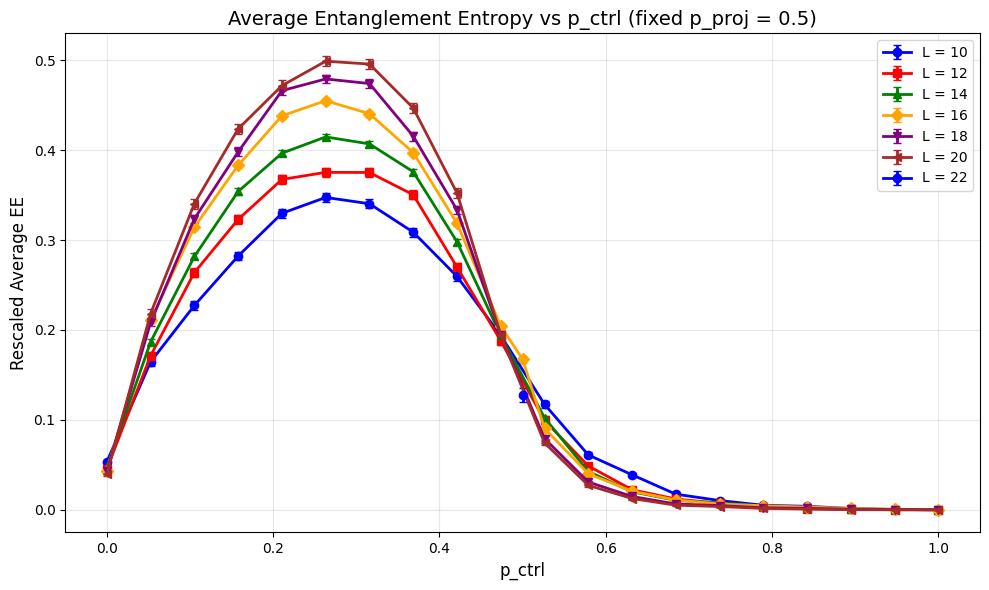


Data summary (varying p_ctrl, fixed p_proj):
L = 10: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: 0.000 ± 0.000 to 0.347 ± 0.005
L = 12: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: 0.000 ± 0.000 to 0.375 ± 0.005
L = 14: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: 0.000 ± 0.000 to 0.415 ± 0.003
L = 16: 21 data points
  p_ctrl range: 0.000 to 1.000
  EE range: 0.000 ± 0.000 to 0.455 ± 0.004
L = 18: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: 0.000 ± 0.000 to 0.479 ± 0.005
L = 20: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.000 ± 0.000 to 0.499 ± 0.006
L = 22: 1 data points
  p_ctrl range: 0.500 to 0.500
  EE range: 0.128 ± 0.008 to 0.128 ± 0.008
cutoff = 1e-09, p_ctrl = 0.0, ensemble size: 2000
cutoff = 1e-09, p_ctrl = 0.05263157894736842, ensemble size: 2000
cutoff = 1e-09, p_ctrl = 0.10526315789473684, ensemble size: 2000
cutoff = 1e-09, p_ctrl = 0.15789473684210525, ensemble size: 2000
cutoff = 1e-09, p_ctrl = 0.

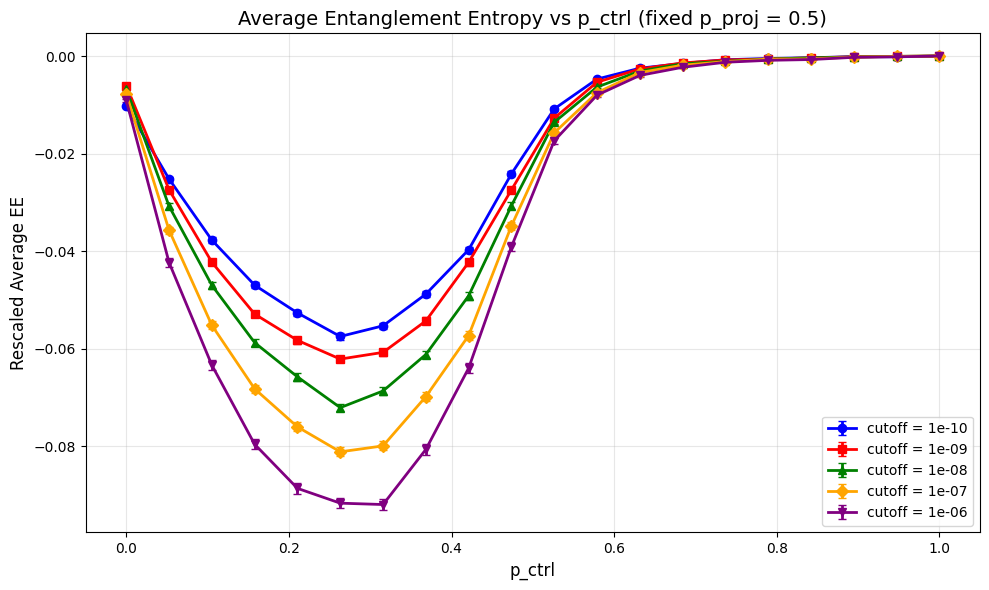


Data summary (varying p_ctrl, fixed p_proj):
cutoff = 1e-10: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.057 ± 0.001 to 0.000 ± 0.000
cutoff = 1e-09: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.062 ± 0.001 to 0.000 ± 0.000
cutoff = 1e-08: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.072 ± 0.001 to 0.000 ± 0.000
cutoff = 1e-07: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.081 ± 0.001 to 0.000 ± 0.000
cutoff = 1e-06: 20 data points
  p_ctrl range: 0.000 to 1.000
  EE range: -0.092 ± 0.001 to 0.000 ± 0.000


In [7]:
# Load data from json_data folder
benchmark_data_path = '/scratch/ty296/precision_benchmark_results/'
data_path = '/scratch/ty296/json_data/'
p_fixed_name = 'p_proj'
p_fixed_value = 0.5
json_data_benchmark = load_data_flexible(benchmark_data_path, p_fixed_name, p_fixed_value)
json_data = load_data_flexible(data_path, p_fixed_name, p_fixed_value)
print(f"Loaded {len(json_data_benchmark)} total data points")
print(json_data_benchmark[0])


# grouped, varying_p_name = group_by(json_data, 'L', 'p_proj')

plot_data_proj = plot_average_EE_vs_p(json_data, groupname='L', p_fixed_name='p_proj', p_fixed_value=0.5, save_plot=True, show_plot=True)

plot_benchmark = plot_average_EE_vs_p(json_data_benchmark, groupname='cutoff', p_fixed_name='p_proj', p_fixed_value=0.5, save_plot=True, show_plot=True)


In [ ]:
# import glob
# import os

# data_path = '/scratch/ty296/json_data/'
# p_fixed_name = 'p_proj'
# p_fixed_value = 0.5
# json_data_benchmark_files = glob.glob(os.path.join(data_path, f'{p_fixed_name}{p_fixed_value}/*.json'))
# print(json_data_benchmark_files[0], len(json_data_benchmark_files))
# count = 0
# for data, json_file in zip(json_data_benchmark, json_data_benchmark_files):
#     print(data['args']['cutoff'])
#     if data['args']['cutoff'] == 1e-7:
#         count += 1
#         os.rename(json_file, os.path.join(data_path, f'{p_fixed_name}{p_fixed_value}/cutoff1e-8/{os.path.basename(json_file)}'))
#     else:
#         print(f'{json_file} is not 1e-8')
# 
# print(count)

/scratch/ty296/json_data/p_proj0.5/44411755_s9439_a0.json 41836
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09
1e-09


In [7]:
# Get all data files recursively from json_data directory
data_path = '/scratch/ty296/json_data/'
all_json_files = []

# Walk through all subdirectories
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.json'):
            # Get full path to json file
            json_path = os.path.join(root, file)
            all_json_files.append(json_path)

print(f"Found {len(all_json_files)} total JSON files")
print("\nExample files:")
# [32331:32332]
counter = 0
for file in all_json_files:  # Print first 5 files as examples
    with open(file, 'r') as f:
        # Look for cutoff parameter in each line of the file
        data = f.readlines()
        try:
            first_line = data[0]
            json_data = json.loads(first_line)
            if 'args' not in json_data or 'cutoff' not in json_data['args']:
                continue
            if json_data['args']['cutoff'] == 1e-6:
                target_dir = f'/scratch/ty296/precision_benchmark_results/{json_data["args"]["p_fixed_name"]}{json_data["args"]["p_fixed_value"]}/cutoff{json_data["args"]["cutoff"]}'
                os.makedirs(target_dir, exist_ok=True)
                
            # Move the file
            target_path = os.path.join(target_dir, os.path.basename(file))
            os.rename(file, target_path)
            counter += 1
        except:
            continue
        # if len(data) > 1:
        #     first_line = data[0]
        # else:
        #     first_line = data
        # print(data)
        # for line in data:
        #     print(line)
        # first_line = data[0]
        # if len(data) > 1:
        #     first_line = data[0]
            counter += 1
print(counter)


#         for line in data:
#             try:
#                 json_data = json.loads(line)
#                 # print(json_data)
#                 if 'args' not in json_data or 'cutoff' not in json_data['args']:
#                     continue
#                 # if json_data['args']['cutoff'] == 1e-7:
#                 # Create target directory if it doesn't exist
#                 target_dir = f'/scratch/ty296/precision_benchmark_results/{json_data["args"]["p_fixed_name"]}{json_data["args"]["p_fixed_value"]}/cutoff{json_data["args"]["cutoff"]}'
#                 os.makedirs(target_dir, exist_ok=True)
                
#                 # Move the file
#                 target_path = os.path.join(target_dir, os.path.basename(file))
#                 os.rename(file, target_path)
#                 counter += 1
#             except json.JSONDecodeError:
#                 continue

# # print(counter)

Found 43956 total JSON files

Example files:
0
